In [107]:
!python -m spacy download en_core_web_lg

2022-11-06 10:27:44.781824: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 11 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [108]:
import pandas as pd
import numpy as np

In [109]:
import gensim

In [110]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [111]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [112]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [113]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [114]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [115]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [116]:
stop_words = stopwords.words('english')

In [117]:
import re
import string

In [118]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ml_IA/spam.csv',encoding='ISO-8859-1')

In [119]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [121]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [122]:
df.rename({'v1': 'category', 'v2': 'text'}, axis=1, inplace=True)

In [123]:
df.head()

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [124]:
df.text[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [125]:
df.category.value_counts()

ham     4825
spam     747
Name: category, dtype: int64

 Using Spacy

In [126]:
def spacy_process(text):
    filtered = []
    doc = nlp(text)
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space:
            continue
        if token.has_vector:
            filtered.append(token.lemma_)
    return " ".join(filtered)

In [127]:
df['spacy_filtered'] = df['text'].apply(spacy_process)

In [128]:
df.head()

,category,text,spacy_filtered
0,ham,"Go until jurong point, crazy.. Available only ...",point crazy available n great world la e buffe...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 comp win FA Cup final 21st 2005 t...
3,ham,U dun say so early hor... U c already then say...,U dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go live


In [129]:
df['spacy_vector'] = df['spacy_filtered'].apply(lambda text: nlp(text).vector)

In [130]:
df['spacy_vector'][0].shape

(300,)

In [131]:
le = LabelEncoder()
y = le.fit_transform(df.category)

In [132]:
np.unique(y, return_counts=True)

(array([0, 1]), array([4825,  747]))

In [133]:
X_train, X_test, y_train, y_test = train_test_split(df.spacy_vector.values, y, 
                                                    test_size=0.2, random_state=42, 
                                                    stratify=y)

In [134]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [135]:
mx_scale = MinMaxScaler()

In [136]:
scaled_fit = mx_scale.fit(X_train_2d)
scaled_train = scaled_fit.transform(X_train_2d)
scaled_test = scaled_fit.transform(X_test_2d)

Modelling using Naive-Bayes

In [137]:
nbc = MultinomialNB()

In [138]:
spacy_nbc_model = nbc.fit(scaled_train, y_train)
spacy_nbc_pred = spacy_nbc_model.predict(scaled_test)

In [139]:
accuracy_score(y_test, spacy_nbc_pred)

0.8645739910313901

In [140]:
confusion_matrix(y_test, spacy_nbc_pred)

array([[962,   4],
       [147,   2]])

2. Gensim Word2Vec

In [141]:
wordnet_lemmatizer = WordNetLemmatizer()

In [142]:
def to_lower(text):
    return text.lower()

In [143]:
def special_character(text):
    return re.sub('[^\w\s]', ' ', text)

In [144]:
def tokenize_text(text):
    return nltk.word_tokenize(text)

In [145]:
def remove_punct(token_list):
    return [token for token in token_list if token not in string.punctuation]

In [146]:
def remove_stop(token_list):
    return [token for token in token_list if token not in stop_words]

In [147]:
def lemmatize_tokens(token_list):
    return [wordnet_lemmatizer.lemmatize(token) for token in token_list]

In [148]:
def preprocess_text(text):
    text = to_lower(text)
    text = special_character(text)
    text = tokenize_text(text)
    text = remove_punct(text)
    text = remove_stop(text)
    text = lemmatize_tokens(text)
    return text

In [149]:
df['filtered'] = df['text'].apply(preprocess_text)

In [150]:
df.head()

,category,text,spacy_filtered,spacy_vector,filtered
0,ham,"Go until jurong point, crazy.. Available only ...",point crazy available n great world la e buffe...,"[1.2490928, 0.89659774, 0.1631842, -0.6977224,...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[-0.14939333, 1.0167166, 0.4778967, -1.6510634...","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 comp win FA Cup final 21st 2005 t...,"[-0.30039942, -3.3519263, 2.5582006, 1.32563, ...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,U dun early hor u c,"[-3.1497614, 2.9741237, 3.1699975, -1.5791801,...","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go live,"[0.055519976, 3.9397497, -4.2775974, -0.347967...","[nah, think, go, usf, life, around, though]"


In [151]:
tokens = pd.Series(df.filtered.values)

Continous Bag of Words and Skipgram

In [152]:
cbow_model = gensim.models.Word2Vec(tokens, size=300, min_count=2)
sgram_model = gensim.models.Word2Vec(tokens, size=300, min_count=2, sg=1)

In [153]:
print('cbow model vocabulary size:', len(cbow_model.wv.vocab))

print('skgram model vocabulary size:', len(sgram_model.wv.vocab))

cbow model vocabulary size: 3976
skgram model vocabulary size: 3976


In [154]:
cbow_model.wv.most_similar('great')

[('get', 0.9999744892120361),
 ('want', 0.9999738335609436),
 ('one', 0.9999732375144958),
 ('see', 0.9999731779098511),
 ('like', 0.9999729990959167),
 ('time', 0.9999729990959167),
 ('think', 0.9999717473983765),
 ('got', 0.9999716877937317),
 ('day', 0.9999715089797974),
 ('much', 0.9999714493751526)]

In [155]:
sgram_model.wv.most_similar('great')

[('wish', 0.9991785287857056),
 ('many', 0.9984562397003174),
 ('always', 0.9983263611793518),
 ('life', 0.9981328845024109),
 ('fine', 0.9979397058486938),
 ('something', 0.9976993799209595),
 ('sure', 0.9974399209022522),
 ('sweet', 0.9973887205123901),
 ('see', 0.997302770614624),
 ('lot', 0.9972258806228638)]

In [158]:
file_name = '/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin'

In [159]:
google_model = gensim.models.KeyedVectors.load_word2vec_format(file_name, binary=True)

Word embeddings to Sentence embeddings

In [160]:
def get_mean_vector(word2vec_model, words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in word2vec_model.wv.vocab]
    if len(words) >= 1:
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        return np.nan #nan easier to work with

In [161]:
df['cbow_vectors'] = df['filtered'].apply(lambda x: get_mean_vector(cbow_model, x))

In [162]:
df['sgram_vectors'] = df['filtered'].apply(lambda x: get_mean_vector(sgram_model, x))

In [163]:
df['google_vectors'] = df['filtered'].apply(lambda x: get_mean_vector(google_model, x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [164]:
df.head(2)

,category,text,spacy_filtered,spacy_vector,filtered,cbow_vectors,sgram_vectors,google_vectors
0,ham,"Go until jurong point, crazy.. Available only ...",point crazy available n great world la e buffe...,"[1.2490928, 0.89659774, 0.1631842, -0.6977224,...","[go, jurong, point, crazy, available, bugis, n...","[0.061232794, 0.035926066, 0.023524737, 0.1038...","[0.028134834, 0.00937459, 0.011556619, 0.03876...","[-0.019805908, 0.05167062, 0.02709961, 0.21868..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[-0.14939333, 1.0167166, 0.4778967, -1.6510634...","[ok, lar, joking, wif, u, oni]","[0.05239159, 0.030949315, 0.020379933, 0.08896...","[0.02385136, 0.011832535, 0.016084135, 0.03575...","[-0.06323496, 0.0803833, 0.060943604, 0.102498..."


In [165]:
df.shape

(5572, 8)

In [166]:
df.isnull().sum()

category           0
text               0
spacy_filtered     0
spacy_vector       0
filtered           0
cbow_vectors      23
sgram_vectors     23
google_vectors    13
dtype: int64

In [167]:
df[df['cbow_vectors'].isnull() == True]

,category,text,spacy_filtered,spacy_vector,filtered,cbow_vectors,sgram_vectors,google_vectors
252,ham,What you doing?how are you?,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],NaN,NaN,NaN
450,ham,hanks lotsly!,hank,"[0.847, -1.4126, -2.1883, 0.54246, -0.60491, -...","[hank, lotsly]",NaN,NaN,"[-0.28515625, 0.19921875, -0.020385742, 0.0893..."
508,ham,What's the significance?,significance,"[0.11191, 1.1441, 0.15109, 0.76535, 5.5421, -0...",[significance],NaN,NaN,"[0.35351562, 0.123535156, 0.13867188, -0.08105..."
782,ham,Beerage?,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[beerage],NaN,NaN,NaN
892,ham,Nutter. Cutter. Ctter. Cttergg. Cttargg. Ctarg...,Nutter cutter ie,"[-1.8332567, -0.16826333, 0.35149994, 1.981266...","[nutter, cutter, ctter, cttergg, cttargg, ctar...",NaN,NaN,"[0.15352376, -0.060139973, 0.010823567, 0.2753..."
959,ham,Where @,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],NaN,NaN,NaN
1444,ham,Those ducking chinchillas,duck chinchilla,"[0.28169, -0.79243004, 0.064450026, -0.3465350...","[ducking, chinchilla]",NaN,NaN,"[0.06542969, 0.12884521, -0.017578125, 0.04931..."
1591,ham,That's my honeymoon outfit. :),honeymoon outfit,"[-1.4281, 1.2529299, -2.1382, -3.04635, 0.2505...","[honeymoon, outfit]",NaN,NaN,"[0.002319336, -0.07751465, -0.29681396, 0.0080..."
1611,ham,645,645,"[-0.83258, -2.923, 2.1926, -1.1998, -0.93677, ...",[645],NaN,NaN,NaN
1835,ham,* Will be september by then!,september,"[-3.0635, -1.7593, -1.3114, -0.81801, 1.9146, ...",[september],NaN,NaN,"[-0.06738281, 0.0017547607, -0.20019531, 0.341..."


In [168]:
df = df.dropna().reset_index(drop=True)
df.head(3)

,category,text,spacy_filtered,spacy_vector,filtered,cbow_vectors,sgram_vectors,google_vectors
0,ham,"Go until jurong point, crazy.. Available only ...",point crazy available n great world la e buffe...,"[1.2490928, 0.89659774, 0.1631842, -0.6977224,...","[go, jurong, point, crazy, available, bugis, n...","[0.061232794, 0.035926066, 0.023524737, 0.1038...","[0.028134834, 0.00937459, 0.011556619, 0.03876...","[-0.019805908, 0.05167062, 0.02709961, 0.21868..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[-0.14939333, 1.0167166, 0.4778967, -1.6510634...","[ok, lar, joking, wif, u, oni]","[0.05239159, 0.030949315, 0.020379933, 0.08896...","[0.02385136, 0.011832535, 0.016084135, 0.03575...","[-0.06323496, 0.0803833, 0.060943604, 0.102498..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 comp win FA Cup final 21st 2005 t...,"[-0.30039942, -3.3519263, 2.5582006, 1.32563, ...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[0.049947415, 0.029586077, 0.019376911, 0.0849...","[0.024344182, 0.01012659, -0.012026076, 0.0349...","[-0.02578699, -0.009852818, -0.05720856, 0.116..."


In [169]:
df.shape

(5547, 8)

In [170]:
X_cbow = pd.DataFrame(df['cbow_vectors'].values.tolist())
X_sgram = pd.DataFrame(df['sgram_vectors'].values.tolist())
X_google = pd.DataFrame(df['google_vectors'].values.tolist())

In [171]:
X_cbow.shape, X_sgram.shape, X_google.shape

((5547, 300), (5547, 300), (5547, 300))

In [172]:
df.category.value_counts()

ham     4801
spam     746
Name: category, dtype: int64

In [173]:
label_encode = LabelEncoder()

In [174]:
y = label_encode.fit_transform(df['category'])
y

array([0, 0, 1, ..., 0, 0, 0])

In [175]:
np.unique(y, return_counts=True)

(array([0, 1]), array([4801,  746]))

In [176]:
X_train_cbow, X_test_cbow, y_train_cbow, y_test_cbow = train_test_split(X_cbow, y, 
                                                                        test_size=0.2, 
                                                                        random_state=42, 
                                                                        stratify=y)

In [177]:
X_train_cbow.shape, X_test_cbow.shape

((4437, 300), (1110, 300))

In [178]:
y_train_cbow.shape, y_test_cbow.shape

((4437,), (1110,))

In [179]:
X_train_sgram, X_test_sgram, y_train_sgram, y_test_sgram = train_test_split(X_sgram, y, 
                                                                            test_size=0.2, 
                                                                            random_state=42, 
                                                                            stratify=y)

In [180]:
X_train_google, X_test_google, y_train_google, y_test_google = train_test_split(X_google, y, 
                                                                                test_size=0.2, 
                                                                                random_state=42, 
                                                                                stratify=y)

Modelling

In [181]:
def build_model(model_name, train_data, test_data):
    train_X, train_y = train_data
    test_X, test_y = test_data
    model_fit = model_name.fit(train_X, train_y)
    model_pred = model_fit.predict(test_X)
    print(f'\nAccuracy score is: {accuracy_score(test_y, model_pred)}')
    print(f'\nConfusion matrix: \n{confusion_matrix(test_y, model_pred)}')

CBOW Model

In [182]:
cbow_pipe = Pipeline([('scale_date', MinMaxScaler()), 
                      ('naive_bayes', MultinomialNB())])

In [183]:
build_model(cbow_pipe, (X_train_cbow, y_train_cbow), (X_test_cbow, y_test_cbow))


Accuracy score is: 0.745945945945946

Confusion matrix: 
[[798 163]
 [119  30]]


SKIPGRAM Model

In [184]:
sgram_pipe = Pipeline([('scale_date', MinMaxScaler()), 
                      ('naive_bayes', MultinomialNB())])

In [185]:
build_model(sgram_pipe, (X_train_sgram, y_train_sgram), (X_test_sgram, y_test_sgram))


Accuracy score is: 0.9522522522522523

Confusion matrix: 
[[933  28]
 [ 25 124]]


Google-news Model

In [186]:
google_pipe = Pipeline([('scale_date', MinMaxScaler()), 
                      ('naive_bayes', MultinomialNB())])

In [187]:
build_model(google_pipe, (X_train_google, y_train_google), (X_test_google, y_test_google))



Accuracy score is: 0.8657657657657658

Confusion matrix: 
[[961   0]
 [149   0]]


Using Keras Embedding layer

In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [189]:
from sklearn.model_selection import train_test_split

In [190]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Flatten

In [191]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ml_IA/spam.csv',encoding='ISO-8859-1')

In [192]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [193]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [194]:
df.rename({'v1': 'category', 'v2': 'text'}, axis=1, inplace=True)
df.head()

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [195]:
df.groupby('category').describe().T

category                        ham  \
text count                     4825   
     unique                    4516   
     top     Sorry, I'll call later   
     freq                        30   

category                                                  spam  
text count                                                 747  
     unique                                                653  
     top     Please call our customer service representativ...  
     freq                                                    4

In [196]:
df['category_enc'] = df['category'].map({'ham': 0, 'spam': 1})

In [197]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category_enc'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df['category_enc'])

In [198]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [199]:
train_encoded = tokenizer.texts_to_sequences(X_train)
test_encoded = tokenizer.texts_to_sequences(X_test)
print(train_encoded[0:2])

[[72, 18, 326, 118, 1268], [1, 347, 23, 1269, 665, 5, 422]]


In [200]:
train_len = [len(i) for i in train_encoded]
print(np.median(train_len))
print(np.mean(train_len))
print(np.max(train_len))

12.0
15.757011442674445
189


In [201]:
max_len = 50

In [202]:
train_padded = pad_sequences(train_encoded, maxlen=max_len, padding='post')
test_padded = pad_sequences(test_encoded, maxlen=max_len, padding='post')

In [203]:
test_padded

array([[ 122,  150,   48, ...,    0,    0,    0],
       [   1,   59,    8, ...,    0,    0,    0],
       [  39,   19,   37, ...,    0,    0,    0],
       ...,
       [  37,  549,  700, ...,    0,    0,    0],
       [ 112,    1,  760, ...,    0,    0,    0],
       [ 103,   62, 1100, ...,    0,    0,    0]], dtype=int32)

In [204]:
len(train_encoded[10])

13

In [205]:
len(train_padded[10])

50

In [206]:
vocab_size = len(tokenizer.word_index) + 1

Simple RNN model

In [207]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len))
model.add(SimpleRNN(128, dropout=0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 300)           2375700   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               54912     
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,447,253
Trainable params: 2,447,253
Non-trainable params: 0
_________________________________________________________________


In [208]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [209]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [210]:
history = model.fit(train_padded, 
                    y_train, 
                    epochs=50, 
                    validation_data=[test_padded, y_test], 
                    callbacks=[early_stop], 
                    verbose=2)

Epoch 1/50
140/140 - 11s - loss: 0.4073 - accuracy: 0.8609 - val_loss: 0.3936 - val_accuracy: 0.8664 - 11s/epoch - 76ms/step
Epoch 2/50
140/140 - 9s - loss: 0.3979 - accuracy: 0.8658 - val_loss: 0.3946 - val_accuracy: 0.8664 - 9s/epoch - 63ms/step
Epoch 3/50
140/140 - 9s - loss: 0.4030 - accuracy: 0.8658 - val_loss: 0.4013 - val_accuracy: 0.8664 - 9s/epoch - 63ms/step
Epoch 4/50
140/140 - 9s - loss: 0.3972 - accuracy: 0.8667 - val_loss: 0.3765 - val_accuracy: 0.8664 - 9s/epoch - 63ms/step
Epoch 5/50
140/140 - 9s - loss: 0.3302 - accuracy: 0.8656 - val_loss: 0.3439 - val_accuracy: 0.8637 - 9s/epoch - 64ms/step
Epoch 6/50
140/140 - 9s - loss: 0.2817 - accuracy: 0.8757 - val_loss: 0.3601 - val_accuracy: 0.8735 - 9s/epoch - 64ms/step
Epoch 7/50
140/140 - 9s - loss: 0.1869 - accuracy: 0.9273 - val_loss: 0.3138 - val_accuracy: 0.8834 - 9s/epoch - 63ms/step
Epoch 8/50
140/140 - 9s - loss: 0.1316 - accuracy: 0.9574 - val_loss: 0.3015 - val_accuracy: 0.8978 - 9s/epoch - 62ms/step
Epoch 9/50
140

In [211]:
rnn_data = pd.DataFrame(history.history)
rnn_data.head()

,loss,accuracy,val_loss,val_accuracy
0,0.407313,0.860893,0.393593,0.866368
1,0.397860,0.865829,0.394566,0.866368
2,0.402985,0.865829,0.401269,0.866368
3,0.397178,0.866727,0.376453,0.866368
4,0.330164,0.865605,0.343852,0.863677


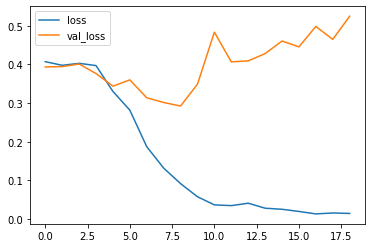

In [212]:
rnn_data[['loss', 'val_loss']].plot()

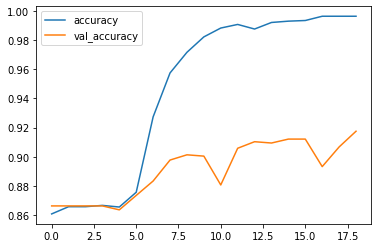

In [213]:
rnn_data[['accuracy', 'val_accuracy']].plot()

In [214]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [215]:
predictions = (model.predict(test_padded) > 0.5).astype('int32')

35/35 [==============================] - 1s 10ms/step


In [216]:
accuracy_score(y_test, predictions)

0.9174887892376682

In [217]:
confusion_matrix(y_test, predictions)

array([[919,  47],
       [ 45, 104]])

SGRAM Model gave best performance